In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torch
!pip install torchtext
!pip install pytorch-nlp

     |████████████████████████████████| 90 kB 3.8 MB/s 


In [ ]:
import torch
import torchtext
from torchtext import data
from torchtext import datasets
from torchnlp.datasets import snli_dataset
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import softmax, relu

from torchtext import vocab
from torchtext.vocab import Vectors, GloVe

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
use_cuda = torch.cuda.is_available()

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    return x.cuda() if use_cuda else x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    return x.cpu().data.numpy() if use_cuda else x.data.numpy()

In [ ]:
device = torch.device('cuda:0')

In [ ]:
inputs = torchtext.legacy.data.Field(sequential=True)
answers = torchtext.legacy.data.Field(sequential=False, unk_token=None)

In [ ]:
train, dev, test = torchtext.legacy.datasets.SNLI.splits(inputs, answers)

downloading snli_1.0.zip


100%|██████████| 94.6M/94.6M [00:04<00:00, 23.5MB/s]


extracting


In [ ]:
inputs.build_vocab(train, dev, test, vectors='glove.840B.300d')

.vector_cache/glove.840B.300d.zip: 2.18GB [06:51, 5.29MB/s]                            
100%|█████████▉| 2196016/2196017 [05:40<00:00, 6442.30it/s]


In [ ]:
answers.build_vocab(train)

In [ ]:
train_iter, dev_iter, test_iter = torchtext.legacy.data.BucketIterator.splits(
            (train, dev, test), batch_size=128, device=device)


In [ ]:
print('train_set.fields:', list(train.fields.keys()))
print('test_set.fields:', list(test.fields.keys()))
print()
print('size of training set', len(train))
print('size of test set', len(test))
print()
print('content of one training sample:')
print(vars(train[4]))

train_set.fields: ['premise', 'hypothesis', 'label']
test_set.fields: ['premise', 'hypothesis', 'label']

size of training set 549367
size of test set 9824

content of one training sample:
{'premise': ['Children', 'smiling', 'and', 'waving', 'at', 'camera'], 'hypothesis': ['There', 'are', 'children', 'present'], 'label': 'entailment'}


# Bag Of Words(BOW)

In [ ]:
num_embeddings = inputs.vocab.vectors.size()[0]
embedding_dim = inputs.vocab.vectors.size()[1]

class BoWNet(nn.Module):

    def __init__(self):
        super(BoWNet, self).__init__()
        
        self.embed = nn.Embedding(num_embeddings, embedding_dim)
        
        self.embed.weight.data.copy_(inputs.vocab.vectors)
        
        self.lin = nn.Linear(600, 600)
        
        self.out_layer = nn.Linear(600, 3)
        
        self.tanh = nn.Tanh()
        
    def forward(self, batch):
        
        prem_embed = self.embed(batch.premise)
        hyp_embed = self.embed(batch.hypothesis)
        
        #shape = [44, 256, 50] === [max size of sentence, batch_size, glove_size]
        
        sum_prem = torch.sum(prem_embed, dim=0)
        sum_hyp = torch.sum(hyp_embed, dim=0)
        
        concat = torch.cat([sum_prem, sum_hyp], dim=1)
        
        #3 layers of 600d with tanh activation
        x = self.lin(concat)
        x = self.tanh(x)
        x = self.lin(x)
        x = self.tanh(x)
        x = self.lin(x)
        x = self.tanh(x)
        
        return softmax(self.out_layer(x), dim=1)

In [ ]:
import math
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

In [ ]:
# define loss function, optimizer, and accuracy metric
# note, you might want to think about the model first
net = BoWNet()
l_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=l_rate, weight_decay=1e-7)

def accuracy(ys, ts):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = torch.eq(torch.max(ys, 1)[1], ts)
    # averaging the one-hot encoded vector
    return torch.mean(correct_prediction.float())
print(net)

BoWNet(
  (embed): Embedding(64280, 300)
  (lin): Linear(in_features=600, out_features=600, bias=True)
  (out_layer): Linear(in_features=600, out_features=3, bias=True)
  (tanh): Tanh()
)


In [ ]:
if use_cuda:
    net.cuda()
    pass
epochs = 10

max_iter = 9000
pr_every = 300
eval_every = 600
train_loss, train_accs = [], []
plt_tr, plt_ev = [], []

step = 0

for epoch in range(epochs):
  train_iter.init_epoch()
  
  for i, batch in enumerate(train_iter):
    net.train()
    
    output = net(batch)
    
    batch_loss = criterion(output, batch.label)
    
    train_loss.append(get_numpy(batch_loss))
    train_accs.append(get_numpy(accuracy(output, batch.label)))
    plt_tr.append((step, get_numpy(accuracy(output, batch.label))))
    
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    step+=1
    
    
    if i % eval_every == 0:
      net.eval(); dev_iter.init_epoch()
      
      eval_loss, eval_accs = [], []
      with torch.no_grad():
        for dev_batch_idx, dev_batch in enumerate(dev_iter):
          answer = net(dev_batch)
          dev_loss = criterion(answer, dev_batch.label)
          
          eval_loss.append(get_numpy(dev_loss))
          eval_accs.append(get_numpy(accuracy(answer, dev_batch.label)))
        plt_ev.append((step, np.mean(eval_accs)))
          
      print("Validation acc: {:.2f}".format(np.mean(eval_accs)))
      print()
    
        
    if i % pr_every == 0:   
      print("epoch: {}, step: {}, Train summary: loss: {:.2f}, acc: {:.2f}".format(epoch, step, np.mean(train_loss), np.mean(train_accs)))
      train_loss, train_accs = [], []

Validation acc: 0.36

epoch: 0, step: 1, Train summary: loss: 1.10, acc: 0.36
epoch: 0, step: 301, Train summary: loss: 1.00, acc: 0.52
Validation acc: 0.59

epoch: 0, step: 601, Train summary: loss: 0.95, acc: 0.58
epoch: 0, step: 901, Train summary: loss: 0.93, acc: 0.60
Validation acc: 0.63

epoch: 0, step: 1201, Train summary: loss: 0.92, acc: 0.61
epoch: 0, step: 1501, Train summary: loss: 0.92, acc: 0.62
Validation acc: 0.63

epoch: 0, step: 1801, Train summary: loss: 0.90, acc: 0.63
epoch: 0, step: 2101, Train summary: loss: 0.90, acc: 0.64
Validation acc: 0.65

epoch: 0, step: 2401, Train summary: loss: 0.89, acc: 0.65
epoch: 0, step: 2701, Train summary: loss: 0.89, acc: 0.65
Validation acc: 0.63

epoch: 0, step: 3001, Train summary: loss: 0.88, acc: 0.66
epoch: 0, step: 3301, Train summary: loss: 0.88, acc: 0.66
Validation acc: 0.65

epoch: 0, step: 3601, Train summary: loss: 0.88, acc: 0.66
epoch: 0, step: 3901, Train summary: loss: 0.87, acc: 0.67
Validation acc: 0.67

epoc

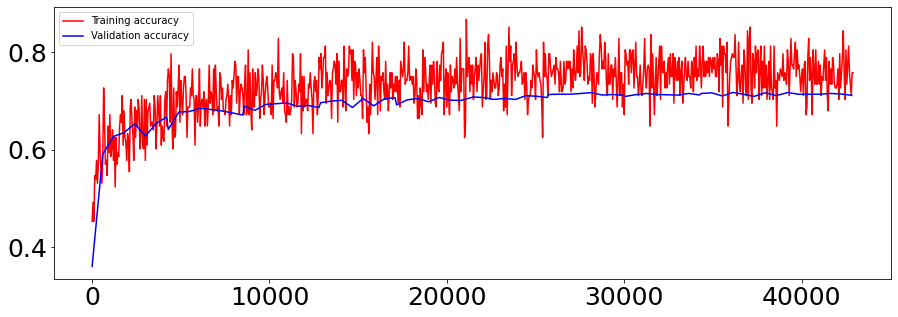

In [ ]:
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
plt.figure(figsize=(15,5))
#plt.title('LSTM performance', fontsize=40)
plt.plot(np.array(plt_tr)[1::50,0], np.array(plt_tr)[1::50,1], label='Training accuracy', color='r')
plt.plot(np.array(plt_ev)[:,0], np.array(plt_ev)[:,1], label='Validation accuracy', color='b')
plt.legend(fontsize=10)
plt.show()

# LSTM model

In [ ]:
num_embeddings = inputs.vocab.vectors.size()[0]
embedding_dim = inputs.vocab.vectors.size()[1]

class LSTMNet(nn.Module):

    def __init__(self):
        super(LSTMNet, self).__init__()
        
        self.embed = nn.Embedding(num_embeddings, embedding_dim)
        
        self.embed.weight.data.copy_(inputs.vocab.vectors)
        
        self.rnn_prem = nn.LSTM(hidden_size = 100, input_size = embedding_dim)
        self.rnn_hyp = nn.LSTM(hidden_size = 100, input_size = embedding_dim)
        
        self.lin = nn.Linear(200, 200)
        self.out_layer = nn.Linear(200, 3)
        
        self.tanh = nn.Tanh()
        
    def forward(self, batch):
        prem_embed = self.embed(batch.premise)
        hyp_embed = self.embed(batch.hypothesis)
        
        #batch_size = batch.premise.size()[1]
        #state_shape = 1, batch_size, 100
        #h0 = c0 =  inputs.new_zeros(state_shape)
        outputs, (htp, ct) = self.rnn_prem(prem_embed)
        outputs, (hth, ct) = self.rnn_hyp(hyp_embed)
        
        concat = torch.cat([htp[-1], hth[-1]], dim=1)
        
        #3 layers of 600d with tanh activation
        x = self.lin(concat)
        x = self.tanh(x)
        x = self.lin(x)
        x = self.tanh(x)
        x = self.lin(x)
        x = self.tanh(x)
        
        return softmax(self.out_layer(x), dim=1)

In [ ]:
# define loss function, optimizer, and accuracy metric
# note, you might want to think about the model first
net = LSTMNet()
l_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=l_rate, weight_decay=1e-7)

def accuracy(ys, ts):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = torch.eq(torch.max(ys, 1)[1], ts)
    # averaging the one-hot encoded vector
    return torch.mean(correct_prediction.float())
print(net)

LSTMNet(
  (embed): Embedding(64280, 300)
  (rnn_prem): LSTM(300, 100)
  (rnn_hyp): LSTM(300, 100)
  (lin): Linear(in_features=200, out_features=200, bias=True)
  (out_layer): Linear(in_features=200, out_features=3, bias=True)
  (tanh): Tanh()
)


In [ ]:
if use_cuda:
    net.cuda()
    pass
epochs = 10

max_iter = 9000
pr_every = 300
eval_every = 600
train_loss, train_accs = [], []
plt_tr, plt_ev = [], []

step = 0

for epoch in range(epochs):
  train_iter.init_epoch()
  
  for i, batch in enumerate(train_iter):
    net.train()
    
    output = net(batch)
    
    batch_loss = criterion(output, batch.label)
    
    train_loss.append(get_numpy(batch_loss))
    train_accs.append(get_numpy(accuracy(output, batch.label)))
    plt_tr.append((step, get_numpy(accuracy(output, batch.label))))
    
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    step+=1
    
    
    if i % eval_every == 0:
      net.eval(); dev_iter.init_epoch()
      
      eval_loss, eval_accs = [], []
      with torch.no_grad():
        for dev_batch_idx, dev_batch in enumerate(dev_iter):
          answer = net(dev_batch)
          dev_loss = criterion(answer, dev_batch.label)
          
          eval_loss.append(get_numpy(dev_loss))
          eval_accs.append(get_numpy(accuracy(answer, dev_batch.label)))
        plt_ev.append((step, np.mean(eval_accs)))
          
      print("Validation acc: {:.2f}".format(np.mean(eval_accs)))
      print()
    
        
    if i % pr_every == 0:   
      print("epoch: {}, step: {}, Train summary: loss: {:.2f}, acc: {:.2f}".format(epoch, step, np.mean(train_loss), np.mean(train_accs)))
      train_loss, train_accs = [], []

Validation acc: 0.33

epoch: 0, step: 1, Train summary: loss: 1.10, acc: 0.32
epoch: 0, step: 301, Train summary: loss: 1.03, acc: 0.47
Validation acc: 0.54

epoch: 0, step: 601, Train summary: loss: 1.01, acc: 0.52
epoch: 0, step: 901, Train summary: loss: 0.98, acc: 0.56
Validation acc: 0.56

epoch: 0, step: 1201, Train summary: loss: 0.97, acc: 0.57
epoch: 0, step: 1501, Train summary: loss: 0.97, acc: 0.57
Validation acc: 0.59

epoch: 0, step: 1801, Train summary: loss: 0.95, acc: 0.59
epoch: 0, step: 2101, Train summary: loss: 0.95, acc: 0.59
Validation acc: 0.51

epoch: 0, step: 2401, Train summary: loss: 0.98, acc: 0.55
epoch: 0, step: 2701, Train summary: loss: 0.97, acc: 0.56
Validation acc: 0.60

epoch: 0, step: 3001, Train summary: loss: 0.94, acc: 0.60
epoch: 0, step: 3301, Train summary: loss: 0.93, acc: 0.61
Validation acc: 0.61

epoch: 0, step: 3601, Train summary: loss: 0.92, acc: 0.62
epoch: 0, step: 3901, Train summary: loss: 0.92, acc: 0.62
Validation acc: 0.62

epoc

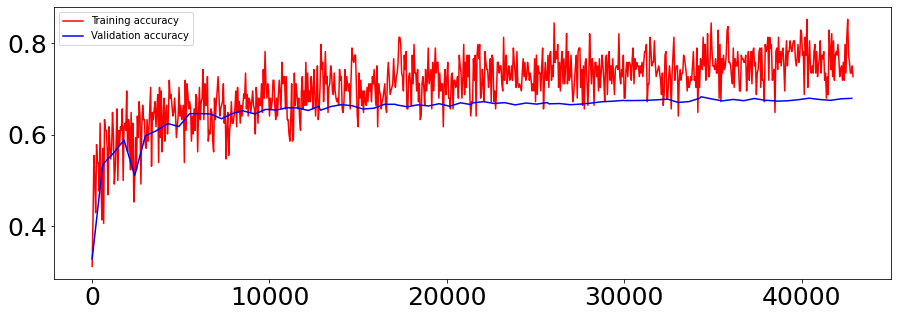

In [ ]:
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
plt.figure(figsize=(15,5))
#plt.title('LSTM performance', fontsize=40)
plt.plot(np.array(plt_tr)[1::50,0], np.array(plt_tr)[1::50,1], label='Training accuracy', color='r')
plt.plot(np.array(plt_ev)[:,0], np.array(plt_ev)[:,1], label='Validation accuracy', color='b')
plt.legend(fontsize=10)
plt.show()